# Coursera IBM Applied Data Science Capstone Project
This notebook will be mainly used for the capstone project.

# Opening a new cafe in Ho Chi Minh City, Vietnam.
HCMC is a thriving city with a 7.5% GDP growth rate. Population has reached over 8 million. Due to the inducing effect by the population and economic acitivites, it has been a hard choice for one to open a restaurant. In this excercise, I will analyze the neighborhood characteristics and will decide the best choice location in opening a new cafe.<br><br>
This analysis follows the steps<br><br>
 -1. Download ward(neighborhood) shapefile, extracting longitude and latitude of the zone.<br>
 -2. Download  POI from foursquare API.<br>
 -3. Conduct K-means clustering<br>
 -4. Visualizing the K-mean cluster<br>
 -5. Getting insights on the cluster to find the new cafe location

## Step 1: Download HCMC ward data

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import os
os.environ['PROJ_LIB'] = r"C:\WBG\Anaconda\Library\share"  

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


Ward shapefile in Vietnam is available at https://opendata.hcmgis.vn/.

In [3]:
vietnam_ward = gpd.read_file('./document/vietnam_wards.shp', encoding = 'utf-8')
vietnam_ward.head()

,OBJECTID,Ma,Ten,Cap,MaQH,QuanHuyen,MaTP,Tinh_Thanh,District,Province,Name,geometry
0,1.0,None,Trung tâm huấn luyện Cấm Sơn,None,219,Huyện Lục Ngạn,24,Tỉnh Bắc Giang,Luc Ngan District,Bac Giang Province,Trung tam huan luyen Cam Son,"POLYGON ((106.8499984740001 21.51603698700006,..."
1,2.0,None,Trung tâm huấn luyện Cấm Sơn,None,220,Huyện Sơn Động,24,Tỉnh Bắc Giang,Son Dong District,Bac Giang Province,Trung tam huan luyen Cam Son,"POLYGON ((106.843231201 21.50239372300007, 106..."
2,3.0,None,Đảo Bạch Long Vĩ,None,318,Huyện Bạch Long Vĩ,31,Thành phố Hải Phòng,Bach Long Vi District,Hai Phong City,Bach Long Vi Island,"POLYGON ((107.7457122800001 20.17039680500005,..."
3,4.0,None,Đảo Cồn Cỏ,None,471,Huyện Cồn Cỏ,45,Tỉnh Quảng Trị,Con Co District,Quang Tri Province,Con Co Insland,(POLYGON ((107.3430862430001 17.14975738500004...
4,5.0,00001,Phường Phúc Xá,Phường,001,Quận Ba Đình,01,Thành phố Hà Nội,Ba Dinh District,Ha Noi City,Phuc Ward,"POLYGON ((105.8492431640001 21.05437660200005,..."


As the shapefile contains all the ward information, I will extract only the ward in HCMC.

In [4]:
# Filtering HCMC
HCMC_ward = vietnam_ward[vietnam_ward['Province'] == 'Ho Chi Minh City'].reset_index(drop = True)
print(HCMC_ward.shape)
HCMC_ward.head()

(322, 12)


,OBJECTID,Ma,Ten,Cap,MaQH,QuanHuyen,MaTP,Tinh_Thanh,District,Province,Name,geometry
0,7818.0,27070,Phường 10,Phường,768,Quận Phú Nhuận,79,Thành phố Hồ Chí Minh,Phu Nhuan District,Ho Chi Minh City,Ward 10,"POLYGON ((106.6699070440001 10.79892248100003,..."
1,7819.0,27073,Phường 11,Phường,768,Quận Phú Nhuận,79,Thành phố Hồ Chí Minh,Phu Nhuan District,Ho Chi Minh City,Ward 11,"POLYGON ((106.6738949840001 10.79012047100002,..."
2,7820.0,27076,Phường 17,Phường,768,Quận Phú Nhuận,79,Thành phố Hồ Chí Minh,Phu Nhuan District,Ho Chi Minh City,Ward 17,"POLYGON ((106.683584001 10.79242040200006, 106..."
3,9753.0,27181,Phường 9,Phường,771,Quận 10,79,Thành phố Hồ Chí Minh,District 10,Ho Chi Minh City,Ward 9,"POLYGON ((106.6724178520001 10.76481844300002,..."
4,7821.0,27079,Phường 14,Phường,768,Quận Phú Nhuận,79,Thành phố Hồ Chí Minh,Phu Nhuan District,Ho Chi Minh City,Ward 14,"POLYGON ((106.668077957 10.78889551900005, 106..."


Next, this geoDataFrame has polygondata, while, for the later K-means cluster analysis,  I need x-y coordinate. I create the centroid of each ward.

In [5]:
HCMC_ward['centroid'] = HCMC_ward.centroid
HCMC_ward.head()

,OBJECTID,Ma,Ten,Cap,MaQH,QuanHuyen,MaTP,Tinh_Thanh,District,Province,Name,geometry,centroid
0,7818.0,27070,Phường 10,Phường,768,Quận Phú Nhuận,79,Thành phố Hồ Chí Minh,Phu Nhuan District,Ho Chi Minh City,Ward 10,"POLYGON ((106.6699070440001 10.79892248100003,...",POINT (106.6710375843309 10.79545185546063)
1,7819.0,27073,Phường 11,Phường,768,Quận Phú Nhuận,79,Thành phố Hồ Chí Minh,Phu Nhuan District,Ho Chi Minh City,Ward 11,"POLYGON ((106.6738949840001 10.79012047100002,...",POINT (106.6747730073135 10.79287978253698)
2,7820.0,27076,Phường 17,Phường,768,Quận Phú Nhuận,79,Thành phố Hồ Chí Minh,Phu Nhuan District,Ho Chi Minh City,Ward 17,"POLYGON ((106.683584001 10.79242040200006, 106...",POINT (106.6826095315289 10.79346395171806)
3,9753.0,27181,Phường 9,Phường,771,Quận 10,79,Thành phố Hồ Chí Minh,District 10,Ho Chi Minh City,Ward 9,"POLYGON ((106.6724178520001 10.76481844300002,...",POINT (106.6706720390022 10.76655795112036)
4,7821.0,27079,Phường 14,Phường,768,Quận Phú Nhuận,79,Thành phố Hồ Chí Minh,Phu Nhuan District,Ho Chi Minh City,Ward 14,"POLYGON ((106.668077957 10.78889551900005, 106...",POINT (106.6683269005768 10.79155555448789)


Then, split the x-y coordinate into the columns of latitude and longitude

In [6]:
HCMC_ward['latitude'] = HCMC_ward.centroid.y
HCMC_ward['longitude'] = HCMC_ward.centroid.x
HCMC_ward.head()

,OBJECTID,Ma,Ten,Cap,MaQH,QuanHuyen,MaTP,Tinh_Thanh,District,Province,Name,geometry,centroid,latitude,longitude
0,7818.0,27070,Phường 10,Phường,768,Quận Phú Nhuận,79,Thành phố Hồ Chí Minh,Phu Nhuan District,Ho Chi Minh City,Ward 10,"POLYGON ((106.6699070440001 10.79892248100003,...",POINT (106.6710375843309 10.79545185546063),10.795452,106.671038
1,7819.0,27073,Phường 11,Phường,768,Quận Phú Nhuận,79,Thành phố Hồ Chí Minh,Phu Nhuan District,Ho Chi Minh City,Ward 11,"POLYGON ((106.6738949840001 10.79012047100002,...",POINT (106.6747730073135 10.79287978253698),10.792880,106.674773
2,7820.0,27076,Phường 17,Phường,768,Quận Phú Nhuận,79,Thành phố Hồ Chí Minh,Phu Nhuan District,Ho Chi Minh City,Ward 17,"POLYGON ((106.683584001 10.79242040200006, 106...",POINT (106.6826095315289 10.79346395171806),10.793464,106.682610
3,9753.0,27181,Phường 9,Phường,771,Quận 10,79,Thành phố Hồ Chí Minh,District 10,Ho Chi Minh City,Ward 9,"POLYGON ((106.6724178520001 10.76481844300002,...",POINT (106.6706720390022 10.76655795112036),10.766558,106.670672
4,7821.0,27079,Phường 14,Phường,768,Quận Phú Nhuận,79,Thành phố Hồ Chí Minh,Phu Nhuan District,Ho Chi Minh City,Ward 14,"POLYGON ((106.668077957 10.78889551900005, 106...",POINT (106.6683269005768 10.79155555448789),10.791556,106.668327


Dropping unncecessary columns for simplicity.

In [7]:
HCMC_ward = HCMC_ward[['District', 'Province', 'Name', 'geometry', 'centroid', 'latitude', 'longitude']]
HCMC_ward.columns = ['District', 'Province', 'Neighborhood', 'geometry', 'centroid', 'latitude', 'longitude']
HCMC_ward.head()

,District,Province,Neighborhood,geometry,centroid,latitude,longitude
0,Phu Nhuan District,Ho Chi Minh City,Ward 10,"POLYGON ((106.6699070440001 10.79892248100003,...",POINT (106.6710375843309 10.79545185546063),10.795452,106.671038
1,Phu Nhuan District,Ho Chi Minh City,Ward 11,"POLYGON ((106.6738949840001 10.79012047100002,...",POINT (106.6747730073135 10.79287978253698),10.792880,106.674773
2,Phu Nhuan District,Ho Chi Minh City,Ward 17,"POLYGON ((106.683584001 10.79242040200006, 106...",POINT (106.6826095315289 10.79346395171806),10.793464,106.682610
3,District 10,Ho Chi Minh City,Ward 9,"POLYGON ((106.6724178520001 10.76481844300002,...",POINT (106.6706720390022 10.76655795112036),10.766558,106.670672
4,Phu Nhuan District,Ho Chi Minh City,Ward 14,"POLYGON ((106.668077957 10.78889551900005, 106...",POINT (106.6683269005768 10.79155555448789),10.791556,106.668327


Let's visualize if it works.

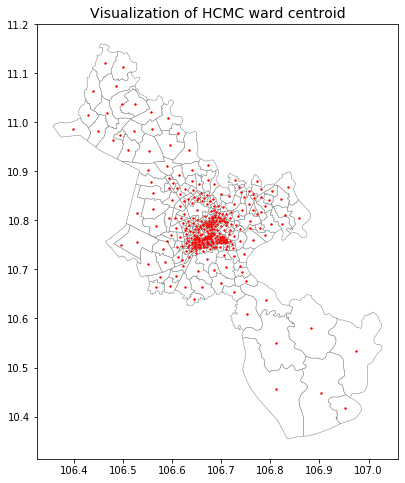

In [8]:
point = gpd.GeoDataFrame(HCMC_ward['centroid'])
point.columns = ['geometry']
fig, ax1 = plt.subplots(figsize = (8, 8))
ax1 = HCMC_ward.plot(ax = ax1, facecolor = 'white', edgecolor = 'gray', linewidth = .5)
ax1.set_title('Visualization of HCMC ward centroid', fontsize = 14)
point.plot(ax = ax1, color = 'red', markersize = 2)

## Step2:  Foursquare API
Now I have created the basemap. We need POI data from Foursquare API to answer the problem set.

In [9]:
CLIENT_ID = '###########' # your Foursquare ID
CLIENT_SECRET = '############' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

Here is the function to extract POI data for all the neighborhood in HCMC.

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url, verify = False).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Applying the function to extract the foursquare data.

In [11]:
HCMC_venues = getNearbyVenues(names = HCMC_ward['Neighborhood'],
                              latitudes = HCMC_ward['latitude'],
                              longitudes = HCMC_ward['longitude'])

Ward 10


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 11


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 17
Ward 9


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 14
Ward 12


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 1
Ward 13


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 14
Ward 13


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 9
Ward 6


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 12
Ward 5


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 11
Ward 2


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 8
Ward 15

C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)



Ward 7

C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)



Ward 1
Ward 11


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 14


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 5
Ward 6


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 10
Ward 13


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ben Thanh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Nguyen Thai Binh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Pham Ngu Lao Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Cau Ong Lanh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Co Giang Ward
Ward 13


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Nguyen Cu Trinh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Cau kho Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 8
Ward 9


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 12
Ward 12


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 12
Ward 11


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 13


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 6


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 9
Ward 10


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 13
Ward 1


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Hiep Thanh Ward
Ward 3


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


An Lac A Ward
Tan Thuan Dong Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 11
Ward 7


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Thanh Xuan Ward
Truong Tho Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Phu Tho Hoa Ward
Long Binh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Long Thanh My Ward
Tan Phu Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Hiep Phu Ward
Tang Nhon Phu A Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Tang Nhon Phu B Ward
Phuoc Long B Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Phuoc Long A Ward
Truong Thanh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Long Phuoc Ward
Long Truong Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Phuoc Binh Ward
Phu Huu Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 15
Phu Thanh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Long Thoi Ward
Hiep Phuoc Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Thi Tran Can Thanh
Binh Khanh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Tam Thon Hiep Ward
An Thoi Dong Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Thanh An Ward
Long Hoa Ward
Ly Nhon Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding cer

Thoi An Ward
Tan Chanh Hiep Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


An Phu Dong Ward
Tan Thoi Hiep Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Trung My Tay Ward
Tan Hung Thuan Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dong Hung Thuan Ward
Tan Thoi Nhat Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Linh Xuan Ward
Binh Chieu Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Linh Trung Ward
Phu Trung Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Phu My Ward
Tan Tao A Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


An Lac Ward
Ward 10


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 28
Hiep Tan Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Tan Thoi Hoa Ward
Ward 4


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 16
Ward 7


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Binh Hung Hoa Ward
Binh Hung Hoa A Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Binh Hung Hoa B Ward
Binh Tri Dong Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Thao Dien Ward
Hoa Thanh Ward
Ward 24


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 6
Ward 14


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 15
Ward 2


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 1
Ward 3


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 17
Ward 21


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 22
Ward 19


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 5
Ward 7


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 7
Ward 6


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 4
Tan Dinh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Da Kao Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ben Nghe Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Tam Binh Ward
Tam Phu Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Hiep Binh Phuoc Ward
Hiep Binh Chanh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 16
Ward 12


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 14
Thanh Loc Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Nhon Duc Ward
Phu Xuan Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Binh Thuan Ward
Tan Quy Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Phu Thuan Ward
Tan Phu Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Tan Phong Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Tan Thuan Tay Ward
Tan Kieng Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Tan Hung Ward
Thi Tran Cu Chi


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Phu My Hung Ward
An Phu Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Trung Lap Thuong Ward
An Nhon Tay Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Nhuan Duc Ward
Pham Van Coi Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Linh Chieu Ward
Linh Tay Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Linh Dong Ward
Binh Tho Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Hung Long Ward
Ward 12


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 5
Ward 14


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 6
Ward 15


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Da Phuoc Ward
Tan Quy Tay Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Binh Chanh Ward
Quy Duc Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Thi Tran Nha Be
Phuoc Kien Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Phuoc Loc Ward
Xuan Thoi Dong Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Trung Chanh Ward
Ward 14


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Xuan Thoi Thuong Ward
Ba Diem Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Thi Tran Tan Tuc
Pham Van Hai Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Vinh Loc A Ward
Vinh Loc B Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Binh Loi Ward
Le Minh Xuan Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Tan Nhut Ward
Tan Kien Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Binh Hung Ward
Phong Phu Ward
An Phu Tay Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding cer

Ward 7
Ward 8


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 2


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 4


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 7
Ward 5


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 6
Ward 3


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 15
Ward 5


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 14


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 11
Ward 3


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 10


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 8
Ward 2


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 1
Ward 3


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 11
Ward 9


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 10
Ward 4


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 13


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 2


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 15
Ward 1


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 4


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 9
Ward 3


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 10
Ward 5


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 18
Ward 14


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 4
Ward 3


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 16
Ward 15


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 1
Ward 2


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 16
Ward 12


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 13
Ward 9


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 6
Ward 8


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 13
Ward 17


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 6
Ward 5


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 9
Ward 7


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 3
Ward 1


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 2


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 8


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Binh Tri Dong B Ward
Tan Tao Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


An Phu Ward
Binh An Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Binh Trung Dong Ward
Binh Trung Tay Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Binh Khanh Ward
An Khanh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Cat Lai Ward
Thanh My Loi Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


An Loi Dong Ward
Thu Thiem Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 8


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 2
Ward 1


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 4


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 8
Ward 3


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 7
Ward 11


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 27
Ward 26


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 12
Ward 25


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 10
Ward 5


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 7
Ward 4


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 1
Ward 9


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 8
Ward 11


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 3
Ward 13


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 12


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 11


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Tan Quy Ward
Tan Thanh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 5
Ward 10


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 6
Ward 8


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 9
Ward 14


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 15
Tan Son Nhi Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Tay Thanh Ward
Son Ky Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 10
Ward 4


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 5


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 3
Ward 2


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 1
Ward 15


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 13
Ward 14


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 2


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 4


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Ward 12
Binh Tri Dong A Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Phu Hoa Dong Ward
Trung Lap Ha Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Trung An Ward
Phuoc Thanh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Phuoc Hiep Ward
Tan An Hoi Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Phuoc Vinh An Ward
Thai My Ward
Tan Thanh Tay Ward
Hoa Phu Ward

C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)



Tan Thanh Dong Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Binh My Ward
Tan Phu Trung Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Tan Thong Hoi Ward
Thi Tran Hoc Mon


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Tan Hiep Ward
Nhi Binh Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dong Thanh Ward
Tan Thoi Nhi Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Thoi Tam Thon Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Xuan Thoi Son Ward
Tan Xuan Ward


C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\WBG\Anaconda\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Let's see the result.

In [12]:
print('We have extracted {} data from foursquare API'.format(HCMC_venues.shape[0]))
HCMC_venues.head()

We have extracted 2955 data from foursquare API


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ward 10,10.795452,106.671038,Cơm Tấm Ba Ghiền,10.794489,106.669443,Vietnamese Restaurant
1,Ward 10,10.795452,106.671038,EASTIN Grand Hotel Saigon,10.796807,106.673363,Hotel
2,Ward 10,10.795452,106.671038,Tung Garden,10.796832,106.673386,Cantonese Restaurant
3,Ward 10,10.795452,106.671038,Hoàng Ty,10.795368,106.672420,Vietnamese Restaurant
4,Ward 10,10.795452,106.671038,TEE Cafe,10.797190,106.670562,Café


In [13]:
# Observe the percentage of the venue category.
HCMC_venues['Venue Category'].value_counts(normalize = True).head(15)

Vietnamese Restaurant            0.137733
Café                             0.136379
Coffee Shop                      0.066328
Asian Restaurant                 0.044332
Chinese Restaurant               0.034518
Seafood Restaurant               0.032487
Hotel                            0.025719
Vegetarian / Vegan Restaurant    0.019966
Dessert Shop                     0.019289
Noodle House                     0.017259
Japanese Restaurant              0.016920
BBQ Joint                        0.015567
Food Truck                       0.014552
Restaurant                       0.013536
Flea Market                      0.012521
Name: Venue Category, dtype: float64

#### Create dummy variable by venue category, and add and moving the number of columns of Neighborhood.

In [14]:
# Create dummy variables by venue category
HCMC_dummy = pd.get_dummies(HCMC_venues[['Venue Category']], prefix="", prefix_sep="")
HCMC_dummy.head(1)

,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,...,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [15]:
# Inseart Neighborhood column
HCMC_dummy['Neighborhood'] = HCMC_venues['Neighborhood'] 
HCMC_dummy.head(1)

,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Women's Store,Yoga Studio,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Ward 10


In [16]:
# Moving Neighborhood column to the front
fixed_columns = [HCMC_dummy.columns[-1]] + list(HCMC_dummy.columns[:-1])
HCMC_dummy = HCMC_dummy[fixed_columns]
print(HCMC_dummy.shape[0])
HCMC_dummy.head()

2955


,Neighborhood,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Women's Store,Yoga Studio
0,Ward 10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,Ward 10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ward 10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ward 10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Ward 10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Obtaining mean value of each category by neighborhood

In [17]:
HCMC_grouped = HCMC_dummy.groupby('Neighborhood').mean().reset_index()
print(HCMC_grouped.shape[0])
HCMC_grouped.head(3)

121


,Neighborhood,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Women's Store,Yoga Studio
0,An Khanh Ward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,An Lac A Ward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,An Loi Dong Ward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0


#### Sort most frequent category in each neighborhood.

In [18]:
# Function to return most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
# Return most frequent venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = HCMC_grouped['Neighborhood']

for ind in np.arange(HCMC_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(HCMC_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape[0])
neighborhoods_venues_sorted.head()

121


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,An Khanh Ward,Vietnamese Restaurant,Yoga Studio,Diner,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store
1,An Lac A Ward,Fast Food Restaurant,Asian Restaurant,Coffee Shop,Seafood Restaurant,Food,Flower Shop,Flea Market,Fish & Chips Shop,Farmers Market,Farm
2,An Loi Dong Ward,Café,Convenience Store,Vietnamese Restaurant,Bubble Tea Shop,Yoga Studio,Dive Bar,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
3,An Phu Dong Ward,Resort,Yoga Studio,Diner,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Eastern European Restaurant
4,An Phu Ward,Vietnamese Restaurant,Yoga Studio,Diner,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store


## Step3: Conduct K-means clustering

In [20]:
# set number of clusters
kclusters = 5

# Drop neighborhood as it is not related with scoring.
HCMC_grouped_clustering = HCMC_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(HCMC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 1, 4, 0, 4, 4, 4, 0, 4])

In [21]:
# Inseart clustering labels to the dataframe
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [22]:
# Merge the original neighborhood dataset and cluster labelled dataframe.
HCMC_merged = HCMC_ward
HCMC_merged = HCMC_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
print('Number of row is {}'.format(HCMC_merged.shape[0]))
print('Number of observation by clusters is\n{}'.format(HCMC_merged['Cluster Labels'].value_counts()))
print(HCMC_merged.isnull().sum())
HCMC_merged.head()

Number of row is 322
Number of observation by clusters is
4.0    228
0.0     20
1.0     16
2.0      3
3.0      3
Name: Cluster Labels, dtype: int64
District                   0
Province                   0
Neighborhood               0
geometry                   0
centroid                   0
latitude                   0
longitude                  0
Cluster Labels            52
1st Most Common Venue     52
2nd Most Common Venue     52
3rd Most Common Venue     52
4th Most Common Venue     52
5th Most Common Venue     52
6th Most Common Venue     52
7th Most Common Venue     52
8th Most Common Venue     52
9th Most Common Venue     52
10th Most Common Venue    52
dtype: int64


,District,Province,Neighborhood,geometry,centroid,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Phu Nhuan District,Ho Chi Minh City,Ward 10,"POLYGON ((106.6699070440001 10.79892248100003,...",POINT (106.6710375843309 10.79545185546063),10.795452,106.671038,4.0,Café,Vietnamese Restaurant,Coffee Shop,Seafood Restaurant,Chinese Restaurant,Snack Place,Hotpot Restaurant,Dim Sum Restaurant,Bookstore,Breakfast Spot
1,Phu Nhuan District,Ho Chi Minh City,Ward 11,"POLYGON ((106.6738949840001 10.79012047100002,...",POINT (106.6747730073135 10.79287978253698),10.792880,106.674773,4.0,Café,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Dessert Shop,Seafood Restaurant,BBQ Joint,Korean Restaurant,Ice Cream Shop,Supermarket
2,Phu Nhuan District,Ho Chi Minh City,Ward 17,"POLYGON ((106.683584001 10.79242040200006, 106...",POINT (106.6826095315289 10.79346395171806),10.793464,106.682610,4.0,Café,Vietnamese Restaurant,Coffee Shop,Seafood Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,BBQ Joint,Soup Place,Spa,Beer Garden
3,District 10,Ho Chi Minh City,Ward 9,"POLYGON ((106.6724178520001 10.76481844300002,...",POINT (106.6706720390022 10.76655795112036),10.766558,106.670672,4.0,Vietnamese Restaurant,Café,Seafood Restaurant,Coffee Shop,Noodle House,BBQ Joint,Vegetarian / Vegan Restaurant,Bookstore,Asian Restaurant,Market
4,Phu Nhuan District,Ho Chi Minh City,Ward 14,"POLYGON ((106.668077957 10.78889551900005, 106...",POINT (106.6683269005768 10.79155555448789),10.791556,106.668327,4.0,Vietnamese Restaurant,Café,Coffee Shop,Chinese Restaurant,Seafood Restaurant,Dessert Shop,Steakhouse,Flea Market,Vegetarian / Vegan Restaurant,Bakery


In [23]:
# Drop null value and convert cluster labels into integer.
HCMC_merged = HCMC_merged.dropna()
HCMC_merged['Cluster Labels'] = HCMC_merged['Cluster Labels'].astype(int)
print('Number of row is {}.'.format(HCMC_merged.shape[0]))
HCMC_merged.head()

Number of row is 270.


,District,Province,Neighborhood,geometry,centroid,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Phu Nhuan District,Ho Chi Minh City,Ward 10,"POLYGON ((106.6699070440001 10.79892248100003,...",POINT (106.6710375843309 10.79545185546063),10.795452,106.671038,4,Café,Vietnamese Restaurant,Coffee Shop,Seafood Restaurant,Chinese Restaurant,Snack Place,Hotpot Restaurant,Dim Sum Restaurant,Bookstore,Breakfast Spot
1,Phu Nhuan District,Ho Chi Minh City,Ward 11,"POLYGON ((106.6738949840001 10.79012047100002,...",POINT (106.6747730073135 10.79287978253698),10.792880,106.674773,4,Café,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Dessert Shop,Seafood Restaurant,BBQ Joint,Korean Restaurant,Ice Cream Shop,Supermarket
2,Phu Nhuan District,Ho Chi Minh City,Ward 17,"POLYGON ((106.683584001 10.79242040200006, 106...",POINT (106.6826095315289 10.79346395171806),10.793464,106.682610,4,Café,Vietnamese Restaurant,Coffee Shop,Seafood Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,BBQ Joint,Soup Place,Spa,Beer Garden
3,District 10,Ho Chi Minh City,Ward 9,"POLYGON ((106.6724178520001 10.76481844300002,...",POINT (106.6706720390022 10.76655795112036),10.766558,106.670672,4,Vietnamese Restaurant,Café,Seafood Restaurant,Coffee Shop,Noodle House,BBQ Joint,Vegetarian / Vegan Restaurant,Bookstore,Asian Restaurant,Market
4,Phu Nhuan District,Ho Chi Minh City,Ward 14,"POLYGON ((106.668077957 10.78889551900005, 106...",POINT (106.6683269005768 10.79155555448789),10.791556,106.668327,4,Vietnamese Restaurant,Café,Coffee Shop,Chinese Restaurant,Seafood Restaurant,Dessert Shop,Steakhouse,Flea Market,Vegetarian / Vegan Restaurant,Bakery


## Step 4: Visualizing the K-mean cluster

In [24]:
# Obtain HCMC coordinates
address = 'Ho Chi Minh City'

geolocator = Nominatim(user_agent="hcmc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toront are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toront are 10.6497452, 106.761979373444.


In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(HCMC_merged['latitude'], HCMC_merged['longitude'], HCMC_merged['Neighborhood'], HCMC_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Also, showing a static map.

In [26]:
# Extract centroid for visualization.
cluster_point = gpd.GeoDataFrame(HCMC_merged[['Cluster Labels', 'centroid']])
cluster_point.columns = ['Cluster Labels', 'geometry']

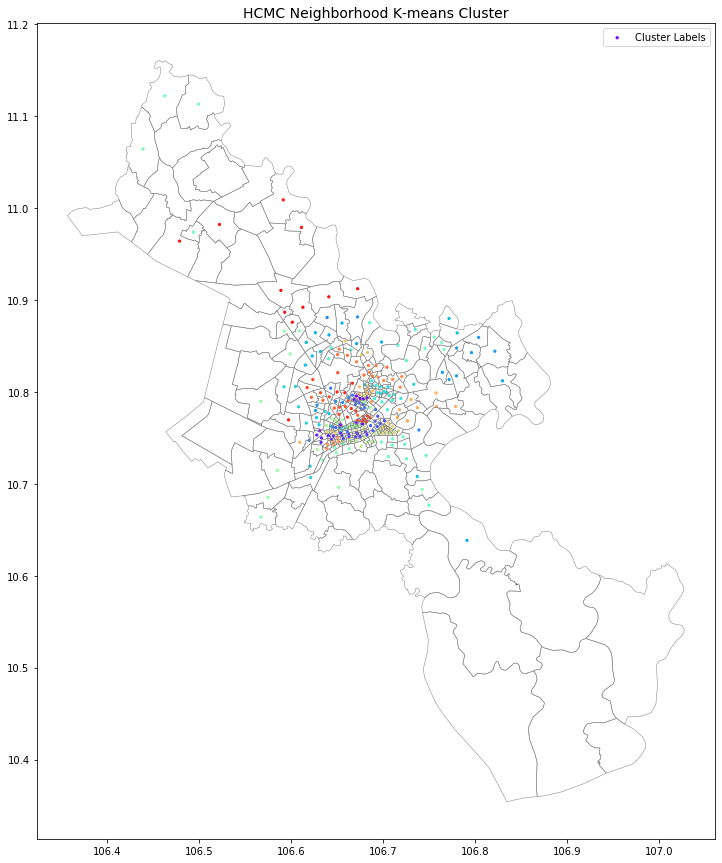

In [27]:
# Show a static map of the cluster.
fig, ax1 = plt.subplots(figsize = (15, 15))
ax1 = cluster_point.plot(ax = ax1, markersize = 5, c = 'Cluster_Labels', marker="o", cmap = 'rainbow', legend = True)
HCMC_ward.plot(ax = ax1, facecolor = 'none', edgecolor = 'gray', linewidth = .5)
ax1.set_title('HCMC Neighborhood K-means Cluster', fontsize = 14)
plt.legend(cluster_point)

## Step 5: Getting insights on the cluster to find the new cafe location

## Analyze Cluster-wise score by category.

In [28]:
# Inseart clustering labels to the dataframe
HCMC_cluster_analysis = HCMC_grouped.copy()
HCMC_cluster_analysis.insert(0, 'Cluster Labels', kmeans.labels_)

In [29]:
# Moving Neighborhood column to the front 
fixed_columns = [HCMC_cluster_analysis.columns[1]] + [HCMC_cluster_analysis.columns[0]] + list(HCMC_cluster_analysis.columns[2:])
HCMC_cluster_analysis = HCMC_cluster_analysis[fixed_columns]
HCMC_cluster_analysis.head()

,Neighborhood,Cluster Labels,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Women's Store,Yoga Studio
0,An Khanh Ward,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,An Lac A Ward,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,An Loi Dong Ward,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0
3,An Phu Dong Ward,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,An Phu Ward,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Create Dataframe for each cluster
Cluster0 = pd.DataFrame(HCMC_cluster_analysis[HCMC_cluster_analysis['Cluster Labels'] == 0]).drop(['Neighborhood', 'Cluster Labels'], axis = 1).sum()
Cluster0 = pd.DataFrame(Cluster0, columns = ['Frequency']).sort_values(by = 'Frequency', ascending = False).reset_index()

Cluster1 = pd.DataFrame(HCMC_cluster_analysis[HCMC_cluster_analysis['Cluster Labels'] == 1]).drop(['Neighborhood', 'Cluster Labels'], axis = 1).sum()
Cluster1 = pd.DataFrame(Cluster1, columns = ['Frequency']).sort_values(by = 'Frequency', ascending = False).reset_index()

Cluster2 = pd.DataFrame(HCMC_cluster_analysis[HCMC_cluster_analysis['Cluster Labels'] == 2]).drop(['Neighborhood', 'Cluster Labels'], axis = 1).sum()
Cluster2 = pd.DataFrame(Cluster2, columns = ['Frequency']).sort_values(by = 'Frequency', ascending = False).reset_index()

Cluster3 = pd.DataFrame(HCMC_cluster_analysis[HCMC_cluster_analysis['Cluster Labels'] == 3]).drop(['Neighborhood', 'Cluster Labels'], axis = 1).sum()
Cluster3 = pd.DataFrame(Cluster3, columns = ['Frequency']).sort_values(by = 'Frequency', ascending = False).reset_index()

Cluster4 = pd.DataFrame(HCMC_cluster_analysis[HCMC_cluster_analysis['Cluster Labels'] == 4]).drop(['Neighborhood', 'Cluster Labels'], axis = 1).sum()
Cluster4 = pd.DataFrame(Cluster4, columns = ['Frequency']).sort_values(by = 'Frequency', ascending = False).reset_index()

#### Cluster 0 score

In [31]:
print('Number of observed variables: {}'.format(len(Cluster0[Cluster0['Frequency']>0])))
Cluster0[Cluster0['Frequency']>0]

Number of observed variables: 12


,index,Frequency
0,Vietnamese Restaurant,13.283333
1,Café,1.933333
2,Soup Place,0.500000
3,Tennis Court,0.500000
4,Home Service,0.500000
5,Mobile Phone Shop,0.500000
6,Restaurant,0.450000
7,Asian Restaurant,0.416667
8,Shopping Mall,0.250000
9,Convenience Store,0.250000


#### Cluster 1 score

In [32]:
print('Number of observed variables: {}'.format(len(Cluster1[Cluster1['Frequency']>0])))
Cluster1[Cluster1['Frequency']>0]

Number of observed variables: 13


,index,Frequency
0,Café,11.066667
1,Bakery,1.000000
2,Vietnamese Restaurant,0.850000
3,Park,0.500000
4,Chinese Restaurant,0.500000
5,Diner,0.500000
6,Asian Restaurant,0.333333
7,Steakhouse,0.250000
8,Convenience Store,0.200000
9,Bubble Tea Shop,0.200000


#### Cluster 2 score

In [33]:
print('Number of observed variables: {}'.format(len(Cluster2[Cluster2['Frequency']>0])))
Cluster2[Cluster2['Frequency']>0]

Number of observed variables: 1


,index,Frequency
0,Bubble Tea Shop,2.0


#### Cluster 3 score

In [34]:
print('Number of observed variables: {}'.format(len(Cluster3[Cluster3['Frequency']>0])))
Cluster3[Cluster3['Frequency']>0]

Number of observed variables: 1


,index,Frequency
0,Soccer Field,3.0


#### Cluster 4 score

In [35]:
print('Number of observed variables: {}'.format(len(Cluster4[Cluster4['Frequency']>0])))
Cluster4[Cluster4['Frequency']>0]

Number of observed variables: 193


,index,Frequency
0,Café,7.169016
1,Vietnamese Restaurant,6.707545
2,Coffee Shop,4.336512
3,Asian Restaurant,3.296126
4,Seafood Restaurant,2.136586
5,Resort,2.066667
6,Mobile Phone Shop,1.783130
7,Furniture / Home Store,1.643427
8,Flea Market,1.545282
9,Market,1.341936


From the descriptive analysis, we can call each cluster as<br>
**Cluster 0**: Commercial zone<br>
**Cluster 1**: Cafe zone<br>
**Cluster 2**: Tea shop<br>
**Cluster 3**: Sport facility<br>
**Cluster 4**: Most vibrant neighborhood<br><br>
It seems that the extent of vibrance of neighrhood is ordered by **Cluster 4**, followed by **Cluster 0**.<br>
We will look into the number of cafe in each neighborhood in the cluster whether the cafe is underrepresented in the neighborhood.

## Deeper analysis of finding a good cafe location where underrepresents the number of cafe.

In [162]:
# Create mask of finding cafe/coffee shop
mask1 = HCMC_merged['1st Most Common Venue'].str.contains('Café', case = False)|HCMC_merged['1st Most Common Venue'].str.contains('Coffee', case = False)
mask2 = HCMC_merged['2nd Most Common Venue'].str.contains('Café', case = False)|HCMC_merged['2nd Most Common Venue'].str.contains('Coffee', case = False)
mask3 = HCMC_merged['3rd Most Common Venue'].str.contains('Café', case = False)|HCMC_merged['3rd Most Common Venue'].str.contains('Coffee', case = False)
mask4 = HCMC_merged['4th Most Common Venue'].str.contains('Café', case = False)|HCMC_merged['4th Most Common Venue'].str.contains('Coffee', case = False)
mask5 = HCMC_merged['5th Most Common Venue'].str.contains('Café', case = False)|HCMC_merged['5th Most Common Venue'].str.contains('Coffee', case = False)
mask6 = HCMC_merged['6th Most Common Venue'].str.contains('Café', case = False)|HCMC_merged['6th Most Common Venue'].str.contains('Coffee', case = False)
mask7 = HCMC_merged['7th Most Common Venue'].str.contains('Café', case = False)|HCMC_merged['7th Most Common Venue'].str.contains('Coffee', case = False)
mask8 = HCMC_merged['8th Most Common Venue'].str.contains('Café', case = False)|HCMC_merged['8th Most Common Venue'].str.contains('Coffee', case = False)
mask9 = HCMC_merged['9th Most Common Venue'].str.contains('Café', case = False)|HCMC_merged['9th Most Common Venue'].str.contains('Coffee', case = False)
mask10 = HCMC_merged['10th Most Common Venue'].str.contains('Café', case = False)|HCMC_merged['10th Most Common Venue'].str.contains('Coffee', case = False)

In [150]:
# Create multiple masks
mask_merged = mask1 | mask2 | mask3 | mask4| mask5 | mask6 | mask7 | mask8 | mask9 | mask10

In [163]:
# find underrepresenting cafe in HCMC
HCMC_cafe_underrepresented = HCMC_merged[~mask_merged]
print('Number of neighborhood which underrepresents cafe: {}'.format(HCMC_cafe_underrepresented.shape[0]))
print('Number of neighborhood with less cafe by cluster:\n{}'.format(HCMC_cafe_underrepresented['Cluster Labels'].value_counts()))
HCMC_cafe_underrepresented.head()

Number of neighborhood which underrepresents cafe: 50
Number of neighborhood with less cafe by cluster:
4    30
0    14
3     3
2     3
Name: Cluster Labels, dtype: int64


,District,Province,Neighborhood,geometry,centroid,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,District 1,Ho Chi Minh City,Co Giang Ward,"POLYGON ((106.692676706 10.75829129200002, 106...",POINT (106.6936450244931 10.76227690306983),10.762277,106.693645,4,Vietnamese Restaurant,Hotel,Japanese Restaurant,Spa,Vegetarian / Vegan Restaurant,Italian Restaurant,Food,Steakhouse,Seafood Restaurant,Diner
46,District 12,Ho Chi Minh City,Hiep Thanh Ward,"POLYGON ((106.648776566 10.88116467700007, 106...",POINT (106.6390836419628 10.88082166560549),10.880822,106.639084,4,Supermarket,Flea Market,IT Services,Vietnamese Restaurant,Cosmetics Shop,Bus Station,Diner,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
49,District 7,Ho Chi Minh City,Tan Thuan Dong Ward,"POLYGON ((106.7447795150001 10.75098199700005,...",POINT (106.738872758164 10.75845761954247),10.758458,106.738873,0,Home Service,Vietnamese Restaurant,Yoga Studio,Diner,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store
56,District 9,Ho Chi Minh City,Long Thanh My Ward,"POLYGON ((106.8362108490001 10.85404151100005,...",POINT (106.8215053558466 10.84416381322933),10.844164,106.821505,4,Fountain,Furniture / Home Store,Yoga Studio,Dive Bar,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store
58,District 9,Ho Chi Minh City,Hiep Phu Ward,"POLYGON ((106.7878689980001 10.85491180900004,...",POINT (106.7799119460613 10.84758357512883),10.847584,106.779912,0,Vietnamese Restaurant,Convenience Store,Shopping Mall,Yoga Studio,Diner,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store


As is observed in the above, we have 30 neighborhoods in cluster 4 which have a higher likelihood that the cafe will thrive because of less competition in the neighborhood.

## Visualizing the final short-list neighborhood for opening a new cafe.

In [165]:
# Select the neighborhood of Cluster 4 which underrepresents Cafe.
Cluster4_no_cafe = HCMC_cafe_underrepresented[HCMC_cafe_underrepresented['Cluster Labels'] == 4]
Cluster4_no_cafe.head()

,District,Province,Neighborhood,geometry,centroid,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,District 1,Ho Chi Minh City,Co Giang Ward,"POLYGON ((106.692676706 10.75829129200002, 106...",POINT (106.6936450244931 10.76227690306983),10.762277,106.693645,4,Vietnamese Restaurant,Hotel,Japanese Restaurant,Spa,Vegetarian / Vegan Restaurant,Italian Restaurant,Food,Steakhouse,Seafood Restaurant,Diner
46,District 12,Ho Chi Minh City,Hiep Thanh Ward,"POLYGON ((106.648776566 10.88116467700007, 106...",POINT (106.6390836419628 10.88082166560549),10.880822,106.639084,4,Supermarket,Flea Market,IT Services,Vietnamese Restaurant,Cosmetics Shop,Bus Station,Diner,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
56,District 9,Ho Chi Minh City,Long Thanh My Ward,"POLYGON ((106.8362108490001 10.85404151100005,...",POINT (106.8215053558466 10.84416381322933),10.844164,106.821505,4,Fountain,Furniture / Home Store,Yoga Studio,Dive Bar,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store
62,District 9,Ho Chi Minh City,Phuoc Long A Ward,"POLYGON ((106.769650873 10.81991894300006, 106...",POINT (106.7644933280875 10.82120817625989),10.821208,106.764493,4,Campground,Yoga Studio,Diner,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Eastern European Restaurant
63,District 9,Ho Chi Minh City,Truong Thanh Ward,"POLYGON ((106.8247377630001 10.82564057900004,...",POINT (106.8299168843199 10.81192604083095),10.811926,106.829917,4,Furniture / Home Store,Yoga Studio,Food,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store,Eastern European Restaurant


Visualizing the location with folium.

In [161]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Cluster4_no_cafe['latitude'], Cluster4_no_cafe['longitude'], Cluster4_no_cafe['Neighborhood'], Cluster4_no_cafe['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters